- title: Занятие 7
- author: Ruslan Pashkov
- date: 2023-03-14
- slug: s2_lab07
- ipynb_url: download/s2_lab07.ipynb

# Занятие 7: Анализ графа статей из Википедии

## Описание работы

Данная работа посвящена обработке графа статей Википедии и рассчитана на достижение двух целей:

1. Применение полученных ранее знаний при работе с реальными данными.
2. Осознание ограничений, налагаемых на программы, написанные на языке Python.


## Структура графа статей

Граф статей Википедии является ориентированным и имеет следующую структуру:

* вершинами графа являются статьи;
* ребро соединяет вершины A и B, если в статье A есть ссылка на статью B.

При этом фатически ссылки бывают двух типов: обычные ссылки в тексте статьи и ссылки из статей с перенаправлением. На рисунке ниже приведён пример такого графа:

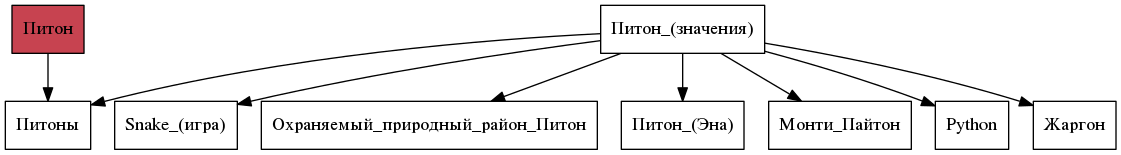




Красным цветом отмечана статья с перенаправлением — если открыть эту статью в браузере, то вместо адреса https://ru.wikipedia.org/wiki/Питон в адресной строке браузера мы увидим https://ru.wikipedia.org/wiki/Питоны. Именно в этом и заключается смысл статей с перенаправлением — они перенаправляют на другую статью. Поэтому вершины графа, соответствующие таким статьям, имеют ровно одно ребро.

## Формат файла с графом

В данной работе граф описывается при помощи текстового файла:

```bash
<m=Количество статей> <n=Количество ссылок>
<Название статьи с номером 0>
<Размер статьи в байтах> <Флаг перенаправления> <n₀=Количество ссылок из статьи>
<Номер статьи, на которую ссылается статья с номером 0>
…
<Номер статьи, на которую ссылается статья с номером 0>
<Название статьи с номером 1>
<Размер статьи в байтах> <Флаг перенаправления> <n₁=Количество ссылок из статьи>
<Номер статьи, на которую ссылается статья с номером 1>
…
<Номер статьи, на которую ссылается статья с номером 1>
…
<Название статьи с номером m-1>
<Размер статьи в байтах> <Флаг перенаправления> <nₘ₋₁=Количество ссылок из статьи>
<Номер статьи, на которую ссылается статья с номером m-1>
…
<Номер статьи, на которую ссылается статья с номером m-1>
```

При этом Σnᵢ=n.

Таким образом, пример графа статей, рассмотренный выше, описывается следующим файлом (указаны произвольные размеры статей):

```bash
9 8
Питон
1 1 1
1
Питоны
7 0 0
Snake_(игра)
9 0 0
Охраняемый_природный_район_Питон
9 0 0
Питон_(Эна)
12 0 0
Монти_Пайтон
99 0 0
Python
45 0 0
Жаргон
23 0 0
Питон_(значения)
53 0 7
1
2
3
4
5
6
7
```

## Способ хранения графа в памяти

### Представление целых чисел в языке Python

Граф статей отражает состояние Википедии и содержит 2854434 вершин и 82096094 рёбер. Размер текстового файла, содержащего описание этого графа, составляет 669 МБайт. При этом, казалось бы, будучи загруженным в оперативную память, граф должен занимать меньше места, чем текстовый файл. Посмотрим, на самом ли деле это так.

Как известно, Python использует ссылочную модель: это означает, что, например, в списке хранятся не сами объекты, а ссылки на них.

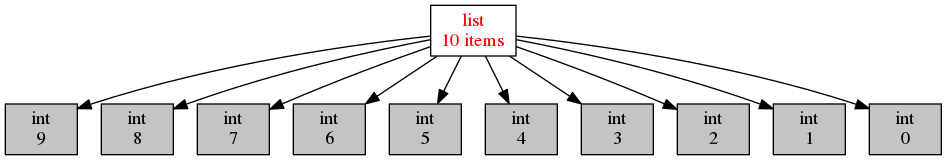

Таким образом, суммарный объём памяти, необходимый для хранения 10 целых чисел может быть вычислен следующим образом: размер списка + 10*(размер целого числа). Для определения объёма памяти, необходимого для хранения объекта, можно воспользоваться функцией `sys.getsizeof`:

```python
>>> import sys
>>> sys.getsizeof(1)
28
>>> sys.getsizeof(10**30)
40
>>> sys.getsizeof(10**10000)
4456
>>> sys.getsizeof([1])
72
>>> sys.getsizeof([1, 2])
80
>>> sys.getsizeof([1, 2, 3, 4, 5, 6])
112
>>> a = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
>>> sys.getsizeof(a) + sum(map(sys.getsizeof, a))
424
```

Теперь оценим объём памяти, необходимый для хранения нашего графа, исходя из следующих предположений:

* средняя длина названия статьи составляет 20 символов;
* все статьи имеют одинаковое количество ссылок на другие статьи.

Для оценки можно построить подобие такой структуры графа в памяти и посчитать её размер:

```python
>>> m = 2854434
>>> n = 82096094
>>> titles = ['а'*20]*m
>>> redirects = [0]*m
>>> sizes = [0]*m
>>> links = [[0]*(n//m)]*m
>>> sz = sys.getsizeof
>>> titles_size = sz(titles) + sum(map(sz, titles))
>>> redirects_size = sz(redirects) + sum(map(sz, redirects))
>>> sizes_size = sz(sizes) + sum(map(sz, sizes))
>>> links_size = sz(links) + sum(map(sz, links)) + sum([sum(map(sz, lnks)) for lnks in links])
>>> (titles_size + redirects_size + sizes_size + links_size) / 1024**3
3.0677924789488316
```

Итого получаем оценку в 3 Гбайт, что практически в пять раз превосходит размер исходного текстового файла. В принципе, с этим можно было бы и смириться, но компьютеры, на которых выполняется эта работа, имеют всего лишь 3 ГБ оперативной памяти, поэтому нужно постараться уменьшить объём памяти, требуемый для хранения графа.

Главная причина такого расхода заключается в том, что для хранения целого числа Python использует объект размером как минимум 28 байт, в то время как для представления чисел из диапазона [0, 4294967296) достаточно всего лишь 4 байт.

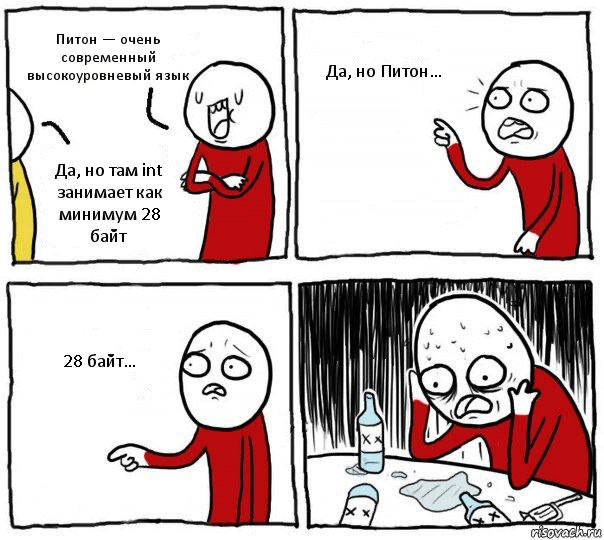

К счастью, в стандартную библиотеку языка Python входит класс [array.array](https://docs.python.org/3.5/library/array.html#array.array), который хранит целые числа в памяти в «сыром» виде. Этот класс является обёрткой над низкоуровневым массивом, поэтому хранит не ссылки на объекты, а непосредственно целые числа в их естественном байтовом представлении. Пример использования такого массива:

```python
>>> import sys
>>> import array
>>> a = array.array('B', [1]*1000)
>>> sys.getsizeof(a)
1064
>>> a = array.array('H', [1]*1000)
>>> sys.getsizeof(a)
2064
>>> a = array.array('I', [1]*1000)
>>> sys.getsizeof(a)
4064
>>> a = array.array('L', [1]*1000)
>>> sys.getsizeof(a)
8064
>>> l = [1]*1000
>>> sys.getsizeof(l) + sum(map(sys.getsizeof, l))
36064
>>> sum(a)
1000
>>> sum(a[0:10])
10
>>> a[-1]
1
>>> sum(a[-1:0:-1])
999
>>> for i in range(1000):
...     a[i] = i
...
>>> sum(a)
499500
```

В качестве параметров конструкутор класса array.array принимает тип хранимых данных, а также список с начальными значениями. Тип хранимых данных, использованный при создании массива, сказывается на размере объекта, а также накладывает ограничения на диапазон хранимых чисел. Вот некоторые из доступных типов (полный список можно посмотреть в официальной [документации](https://docs.python.org/3.5/library/array.html#module-array)):


|Код типа|Тип в языке C|Минимальный размер в байтах|Диапазон чисел|
|--------|-------------|---------------------------|--------------|
|'B'|usigned char|1|[0; 256)|
|'H'|unsigned short|2|[0; 65536)|
|'I'|unsigned int|2|[0; 65536)|
|'L'|unsigned long|4|[0; 4294967296)|

Как можно заметить из примера выше, на архитектуре x86_64 тип с кодом 'I' имеет размер 4 байта, а тип с кодом 'L' — 8 байт. Соответственно, диапазон допустимых значений для первого равен [0; 4294967296), диапазон же второго гораздо шире — [0; 18446744073709551616).

При этом можно заметить как минимум четырёхкратную экономию памяти. В случае же графа статей Википедии можно добиться восьмикратной экономии памяти при хранении целых чисел.

К сожалению, за сокращение расхода памяти приходится платить снижением производительности практически в полтора раза при доступе к элементам массива:

```python
>>> import timeit
>>>
>>> s1 = '''
... l = [0]*1000
... '''
>>>
>>> s2 = '''
... import array
...
... l = [0]*1000
... a = array.array('L', l)
... '''
>>>
>>> timeit.timeit('sum(l)', setup=s1)
8.596833281000727
>>> timeit.timeit('sum(a)', setup=s2)
12.721174658989185
```

Это объясняется тем, что при каждом доступе к элементу массива (чтение или запись) создаётся временный объект типа int, поскольку Python может работать только с «родными» типами данных.

### Компактный способ хранения графа

Теперь перейдём к вопросу о том, каким образом можно представить граф в памяти компьютера без использования списков, словарей и множеств: для этого достаточно двух массивов. Такой способ хранения называется CSR (Compressed Sparse Row) и используется во многих библиотеках, предназначенных для работы с графами (например, METIS). Рассмотрим процесс построения этих массивов на примере графа, изображённого ниже:

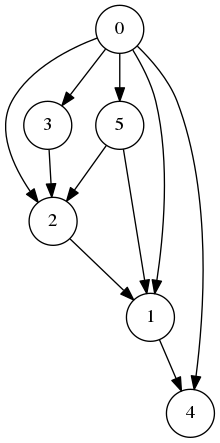

Сначала выпишем все рёбра, отстортировав их по номеру вершины, из которой исходит ребро, и пронумеровав строки:

```bash
(0)   0 --> 1
(1)   0 --> 2
(2)   0 --> 3
(3)   0 --> 4
(4)   0 --> 5
(5)   1 --> 4
(6)   2 --> 1
(7)   3 --> 2
(8)   5 --> 1
(9)   5 --> 2
```

Полученный правый столбец — это содержимое первого массива. Этот массив хранит номера вершин, в которые приходит ребро. Теперь для каждой из пяти вершин выпишем количество рёбер, исходящих из этой вершины:

```bash
(0) 5
(1) 1
(2) 1
(3) 1
(4) 0
(5) 2
```

Теперь построим второй массив по следующему правилу:

* a₀ = 0
* aᵢ = aᵢ₋₁ + <количество рёбер, исходящих из вершины с номером i-1> для 1 ≤ i ≤ m, где m — количество вершин в графе.

Таким образом мы построили два массива. Массив offset содержит индексы в массиве edges, с которых начинаются рёбра, исходящие из соответствующей вершины. Массив edges содержит нормера вершин, в которые приходит ребро. Т.е. из вершины k исходят offset[k+1]-offset[k] ребёр в вершины с индексами edges[offset[k]:offset[k+1]].

```python
>>> import array
>>> edges = array.array('B', [1, 2, 3, 4, 5, 4, 1, 2, 1, 2])
>>> offset = array.array('B', [0, 5, 6, 7, 8, 8, 10])
>>> # рёбра из вершины 0
... edges[offset[0]:offset[1]]
[1, 2, 3, 4, 5]
>>> # рёбра из вершины 1
... edges[offset[1]:offset[2]]
[4]
>>> # рёбра из вершины 2
... edges[offset[2]:offset[3]]
[1]
>>> # рёбра из вершины 3
... edges[offset[3]:offset[4]]
[2]
>>> # рёбра из вершины 4
... edges[offset[4]:offset[5]]
[]
>>> # рёбра из вершины 5
... edges[offset[5]:offset[6]]
[1, 2]
```


## Анализ графа статей

Перейдём непосредственно к практике. Конечная цель работы — получить некоторые статистические данные по графу статей Википедии.

Перед началом выполнения упражнений сделайте форк [репозитория](https://github.com/mipt-cs-on-python3/wiki-stats) с заготовкой для работы.

### Упражнение №1

Реализуйте метод WikiGraph.load_from_file для загрузки графа из текстового файла. Для хранения используйте способ, описанный ранее. В качестве входного файла с описанием графа используйте файл wiki_small.txt из репозитория.

### Упражнение №2

Реализуйте все оставшиеся методы класса WikiGraph.

### Упражнение №3

При помощи реализованных методов определите следующее:

* путь, по которому можно добраться от статьи Python до статьи Список_файловых_систем;
* количество статей с перенаправлением;
* минимальное количество ссылок из статьи;
* количество статей с минимальным количеством ссылок;
* максимальное количество ссылок из статьи;
* количество статей с максимальным количеством ссылок;
* статья с наибольшим количеством ссылок;
* среднее количество ссылок в статье;
* минимальное количество ссылок на статью (перенаправление не считается внешней ссылкой);
* количество статей с минимальным количеством внешних ссылок;
* максимальное количество ссылок на статью;
* количество статей с максимальным количеством внешних ссылок;
* статья с наибольшим количеством внешних ссылок;
* среднее количество внешних ссылок на статью;
* минимальное количество перенаправлений на статью;
* количество статей с минимальным количеством внешних перенаправлений;
* максимальное количество перенаправлений на статью;
* количество статей с максимальным количеством внешних перенаправлений;
* статья с наибольшим количеством внешних перенаправлений;
* среднее количество внешних перенаправлений на статью.
Используйте функции: [sum](https://docs.python.org/3.5/library/functions.html#sum), [min](https://docs.python.org/3.5/library/functions.html#min), [max](https://docs.python.org/3.5/library/functions.html#max), [statistics.mean](https://docs.python.org/3/library/statistics.html#statistics.mean), [statistics.stdev](https://docs.python.org/3/library/statistics.html#statistics.stdev).

Примерно так должны выглядеть результаты работы вашей программы:

```bash
Загружаю граф из файла: wiki_small.txt
Граф загружен
Запускаем поиск в ширину
Поиск закончен. Найден путь:
Python
UNIX
Список_файловых_систем
Количество статей с перенаправлением: 50 (4.13%)
Минимальное количество ссылок из статьи: 0
Количество статей с минимальным количеством ссылок: 3
Максимальное количество ссылок из статьи: 356
Количество статей с максимальным количеством ссылок: 1
Статья с наибольшим количеством ссылок: Python
Среднее количество ссылок в статье: 34.34 (ср. откл. 32.55)

Минимальное количество ссылок на статью: 0
Количество статей с минимальным количеством внешних ссылок: 152
Максимальное количество ссылок на статью: 1000
Количество статей с максимальным количеством внешних ссылок: 1
Статья с наибольшим количеством внешних ссылок: Python
Среднее количество внешних ссылок на статью: 32.92 (ср. откл. 68.47)

Минимальное количество перенаправлений на статью: 0
Количество статей с минимальным количеством внешних перенаправлений: 1171
Максимальное количество перенаправлений на статью: 7
Количество статей с максимальным количеством внешних перенаправлений: 1
Статья с наибольшим количеством внешних перенаправлений: Python
Среднее количество внешних перенаправлений на статью: 0.04 (ср. откл. 0.28)
```

### Упражнение №4

Скачайте [отсюда](ftp://10.55.163.88/pub/wiki.txt.gz) (или [отсюда](https://www.dropbox.com/s/5977miarjdqzcgk/wiki.txt.gz)) полный граф статей Википедии в папку репозитория. Распакуйте его при помощи команды: gzip -dc wiki.txt.gz > wiki.txt. Запустите свою программу, передав в качестве входного файла wiki.txt.

* Получите статистические данные из упражнения №3.
* Найдите путь, по которому можно добраться от статьи [Python](https://ru.wikipedia.org/wiki/Python) до статьи [Боль](https://ru.wikipedia.org/wiki/Боль).